In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training_extra.transfer_learning.meta import fetch_meta
from thesis_v2.training_extra.transfer_learning.analysis import collect_one_setting

In [3]:
folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/transfer_learning_factorized_vgg'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit import param_iterator, sparse_list, feature_file_name
from key_utils import keygen

num_sparse = len(sparse_list)

In [4]:
# # compute cc_max
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)
assert np.all(cc_max_all_neurons > 0)

In [5]:
def load_everything():
    _df_collect = []
    argmax_all = []
    for idx, param in enumerate(param_iterator(include_sparse=False)):
        if idx % 5 == 0:
            print(idx)
        
        assert param['split_seed'] == 'legacy' and param['model_seed'] == 0
        
        # get meta
        with h5py.File(feature_file_name, 'r') as f_feature:
            meta_this = fetch_meta(f_feature['a/' + param['suffix']], 'a/' + param['suffix'])
        assert meta_this['dataset'] == 'a'
        assert meta_this['layer_unroll'] == 0
        
        performance_result = collect_one_setting(
            sparse_list = sparse_list,
            keygen=keygen,
            param=param,
            num_neuron=79,
        )
        assert performance_result['test_best'].shape == (79,)
    
        bn = meta_this['network'].endswith('_bn')
        if bn:
            network_proper = meta_this['network'][:-3]
        else:
            network_proper = meta_this['network']
        _df_collect.append({
            'network': network_proper,
            'scale': meta_this['setting'],
            'loss_type': param['loss_type'],
            'act_fn': param['act_fn'],
            'layer': '{:02d}.{}'.format(meta_this['layer_idx'], meta_this['layer_name']),
            'BN': bn,
            'corr_test': performance_result['test_best'].mean(),
            
            'corr2_normed_test': ((performance_result['test_best']/cc_max_all_neurons)**2).mean(),
        })
        
        # which sparsity setting is used.
        argmax_all.append(performance_result['argmax'])
        
    argmax_all = np.concatenate(argmax_all, axis=0)
    # looks good. most neurons select middle ones.
    
    # remove -1 ones.
    argmax_all = argmax_all[argmax_all!=-1]
    print(np.bincount(argmax_all)/argmax_all.size)

    _df =  pd.DataFrame(_df_collect, columns=['network', 'BN', 'scale', 'loss_type', 'act_fn', 'layer', 'corr_test', 'corr2_normed_test'])
    _df = _df.set_index(['network', 'BN', 'scale', 'loss_type', 'act_fn', 'layer'], verify_integrity=True)
    return _df

In [6]:
# collect all data.
# it's a series.
df_all = load_everything()

df_dict = {
    'legacy': df_all['corr_test'],
    'corr2_normed': df_all['corr2_normed_test'],
}

['vgg11/half/1.0', 'vgg11/half/2.0', 'vgg11/half/3.0', 'vgg11/half/4.0', 'vgg11/half/5.0', 'vgg11/half/6.0', 'vgg11/quarter/1.0', 'vgg11/quarter/2.0', 'vgg11/quarter/3.0', 'vgg11/quarter/4.0', 'vgg11/quarter/5.0', 'vgg11/quarter/6.0', 'vgg11_bn/half/1.0', 'vgg11_bn/half/2.0', 'vgg11_bn/half/3.0', 'vgg11_bn/half/4.0', 'vgg11_bn/half/5.0', 'vgg11_bn/half/6.0', 'vgg11_bn/quarter/1.0', 'vgg11_bn/quarter/2.0', 'vgg11_bn/quarter/3.0', 'vgg11_bn/quarter/4.0', 'vgg11_bn/quarter/5.0', 'vgg11_bn/quarter/6.0', 'vgg16/half/2.0', 'vgg16/half/3.0', 'vgg16/half/4.0', 'vgg16/half/5.0', 'vgg16/half/6.0', 'vgg16/half/7.0', 'vgg16/half/8.0', 'vgg16/half/9.0', 'vgg16/quarter/2.0', 'vgg16/quarter/3.0', 'vgg16/quarter/4.0', 'vgg16/quarter/5.0', 'vgg16/quarter/6.0', 'vgg16/quarter/7.0', 'vgg16/quarter/8.0', 'vgg16/quarter/9.0', 'vgg16_bn/half/2.0', 'vgg16_bn/half/3.0', 'vgg16_bn/half/4.0', 'vgg16_bn/half/5.0', 'vgg16_bn/half/6.0', 'vgg16_bn/half/7.0', 'vgg16_bn/half/8.0', 'vgg16_bn/half/9.0', 'vgg16_bn/quart

In [7]:
# only focus on the split seed == 'legacy' part.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from thesis_v2.plots.basic import scatter
from thesis_v2.plots.util import savefig

In [9]:
def plot_scatter(df_this, key1, key2, level, xlabel, ylabel, key, lim):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(3,3))
    
    x = df_this.xs(key1, level=level).sort_index().values
    y = df_this.xs(key2, level=level).sort_index().values
    
    selector = np.logical_and(np.isfinite(x), np.isfinite(y))
    n = selector.sum()
    assert n > 0
    
    scatter(ax, x[selector], y[selector], xlabel, ylabel, xlim=lim, ylim=lim)
    # TODO set tick labels.
    ax.text(0.05, 0.95, f'N={n}',
            horizontalalignment='left',
            verticalalignment='top', transform=ax.transAxes)
    
    # adjust figure size to make sure the aspect ratio is correct.
    fig.subplots_adjust(left=0.2,bottom=0.2,right=0.9,top=0.9)
    
    # save fig.
    savefig(fig, f'yuanyuan_8k_a_3day/transfer_learning_factorized_vgg/hyperparameter_no_size_change/{key}.pdf')
    
    plt.show()

In [10]:
# df_to_use = df_to_use.xs('relu', level='act_fn')
# if you uncomment this and replot, you can see all those outliers disappear.
# remember to comment out `plot_scatter(df_to_use, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', 'act')`, as act_fn column disappears then.

In [11]:
def get_all_scatters(df_to_use_this, prefix='', lim=(0.3, 0.6)):
    # comments apply to raw cc mean.
    
    plot_scatter(df_to_use_this, 'quarter', 'half', 'scale', 'quarter', 'half', prefix+'input_size', lim)
    plot_scatter(df_to_use_this, 'softplus', 'relu', 'act_fn', 'softplus', 'relu', prefix+'act', lim)
    
    # loss_type
    plot_scatter(df_to_use_this, 'poisson', 'mse', 'loss_type', 'poisson', 'mse', prefix+'loss_type', lim)
    # outliers (those with ~0 performance points) are all due to softplus. check line `df_to_use = df_to_use.xs('relu', level='act_fn')`.
    

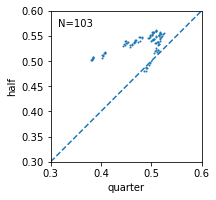

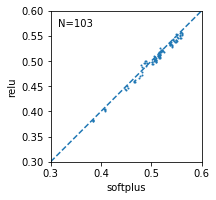

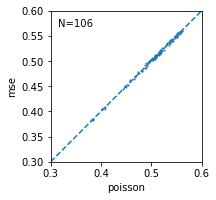

In [12]:
get_all_scatters(df_dict['legacy'])

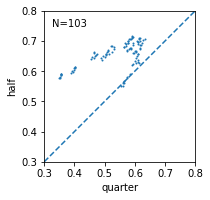

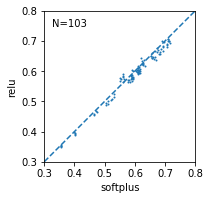

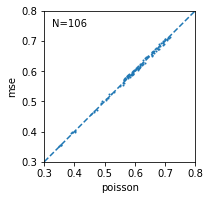

In [13]:
get_all_scatters(df_dict['corr2_normed'], lim=(0.3, 0.8), prefix='corr2normed_')

In [14]:
from thesis_v2.plots.basic import labeled_line

In [15]:
# then plot corr. vs. layer stuff.
def visualize(df_to_use_this, prefix='',ylim=(0.47, 0.57), scale='half', normed_cc2=False):
    for net in df_to_use_this.index.get_level_values('network').unique():
        print(net)
        
        df_this = df_to_use_this.xs(net, level='network')
        df_this_shaped = df_this.xs('mse', level='loss_type').xs('softplus', level='act_fn').xs(scale, level='scale').unstack('BN').sort_index().sort_index(axis=1)
        
        
        df_this_shaped.plot(rot=45, marker='x')
        
        
        print(df_this_shaped)
        assert df_this_shaped.columns.values.tolist() == [False, True]
        
        plt.close('all')
        
        fig, ax = plt.subplots(figsize=(6,4))
        
        labeled_line(ax,
                     [
                         ('no BN', df_this_shaped.values[:,0]),
                         ('BN', df_this_shaped.values[:,1]),
                     ],
                     [s[3:] for s in df_this_shaped.index.values],
                     xlabel='layer',
                     ylabel='mean corr on test set' if not normed_cc2 else 'mean $CC_{\\mathrm{norm}}^2$',
                     ylim=ylim,
                     plot_kwargs={'marker': 'x'},
                     xticklabels_kwargs={'rotation': 45},
                    )
        
        fig.subplots_adjust(bottom=0.225,right=0.975,top=0.975)
        
        savefig(fig,
                f'yuanyuan_8k_a_3day/transfer_learning_factorized_vgg/per_layer_performance/{prefix}{net}.pdf'
               )
        plt.show()

vgg11
BN             False     True 
layer                         
01.pool1    0.486747  0.479741
02.conv2_1       NaN  0.554157
03.pool2    0.548774  0.556281
04.conv3_1  0.558721  0.560477
05.conv3_2  0.545067  0.548001
06.pool3    0.536402  0.538920


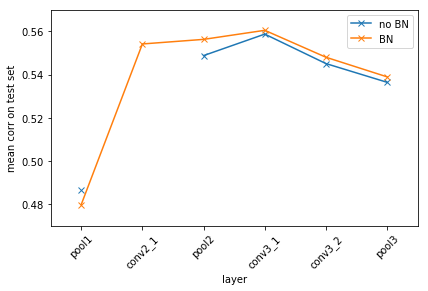

vgg16
BN             False     True 
layer                         
02.pool1    0.516585  0.521288
03.conv2_1       NaN  0.532366
04.conv2_2  0.538309  0.540383
05.pool2    0.542854  0.548332
06.conv3_1  0.551735  0.556911
07.conv3_2  0.536084  0.540107
08.conv3_3  0.515082  0.516067
09.pool3    0.506004  0.507104


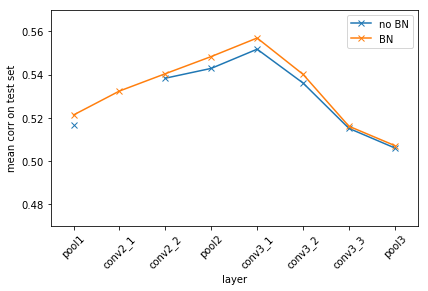

In [16]:
visualize(df_dict['legacy'])
# combine BN.

vgg11
BN             False     True 
layer                         
01.pool1    0.561229  0.549114
02.conv2_1       NaN  0.703165
03.pool2    0.689510  0.708232
04.conv3_1  0.709100  0.713968
05.conv3_2  0.673682  0.681554
06.pool3    0.653264  0.659687


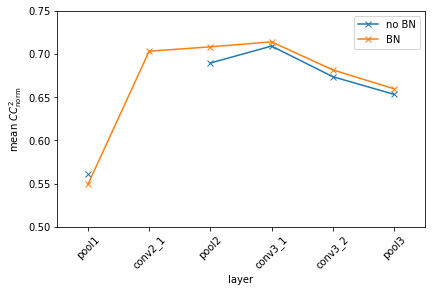

vgg16
BN             False     True 
layer                         
02.pool1    0.621065  0.631423
03.conv2_1       NaN  0.650833
04.conv2_2  0.665036  0.671831
05.pool2    0.673277  0.686415
06.conv3_1  0.691810  0.704747
07.conv3_2  0.653968  0.666408
08.conv3_3  0.608621  0.610771
09.pool3    0.586781  0.589299


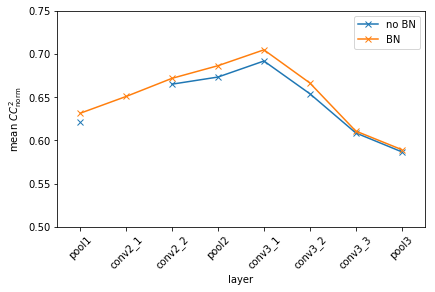

In [17]:
visualize(df_dict['corr2_normed'], prefix='corr2normed_',ylim=(0.5, 0.75),normed_cc2=True)

vgg11
BN             False     True 
layer                         
01.pool1    0.489221  0.485629
02.conv2_1  0.520795  0.522482
03.pool2    0.515407  0.517262
04.conv3_1  0.508399  0.508212
05.conv3_2  0.480686  0.476460
06.pool3    0.452101  0.447924


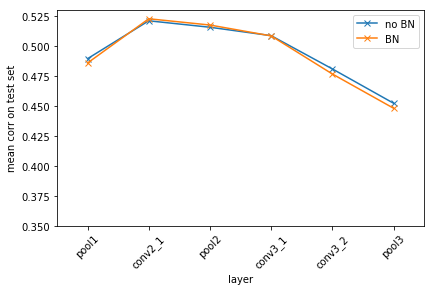

vgg16
BN             False     True 
layer                         
02.pool1    0.504880  0.513166
03.conv2_1  0.514624  0.513665
04.conv2_2  0.512587  0.517505
05.pool2    0.504475  0.508834
06.conv3_1  0.501602  0.502020
07.conv3_2  0.464926  0.467278
08.conv3_3  0.405456  0.407929
09.pool3    0.383889  0.384160


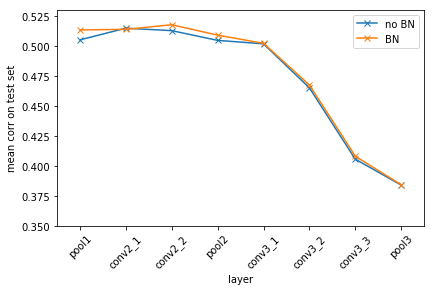

In [18]:
visualize(df_dict['legacy'], prefix='scale_quarter_', scale='quarter', ylim=(0.35,0.53))

vgg11
BN             False     True 
layer                         
01.pool1    0.560805  0.553621
02.conv2_1  0.624109  0.628312
03.pool2    0.610087  0.614789
04.conv3_1  0.591433  0.590337
05.conv3_2  0.531864  0.522805
06.pool3    0.471777  0.463079


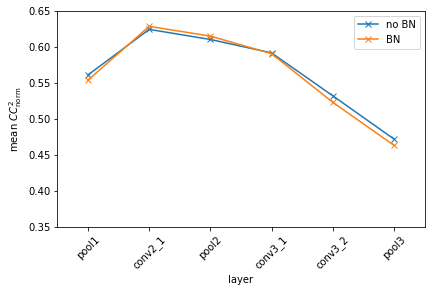

vgg16
BN             False     True 
layer                         
02.pool1    0.590665  0.610854
03.conv2_1  0.607970  0.605777
04.conv2_2  0.604955  0.615774
05.pool2    0.586124  0.594055
06.conv3_1  0.577855  0.580367
07.conv3_2  0.503776  0.511141
08.conv3_3  0.399415  0.401538
09.pool3    0.356918  0.355853


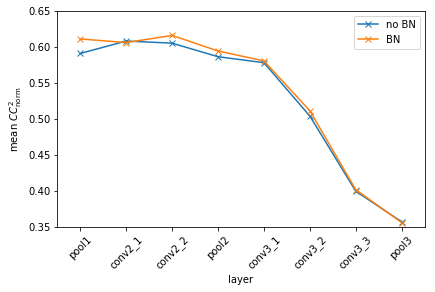

In [19]:
visualize(df_dict['corr2_normed'], prefix='corr2normed_scale_quarter_', scale='quarter',ylim=(0.35, 0.65),normed_cc2=True)